# Recognition tables with text


In [1]:
name_jpg = 'sample_6.jpg'

In [2]:
%matplotlib inline
import pytesseract
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import copy
from PIL import Image

In [3]:
def show_image (img):
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

## Вариант 1

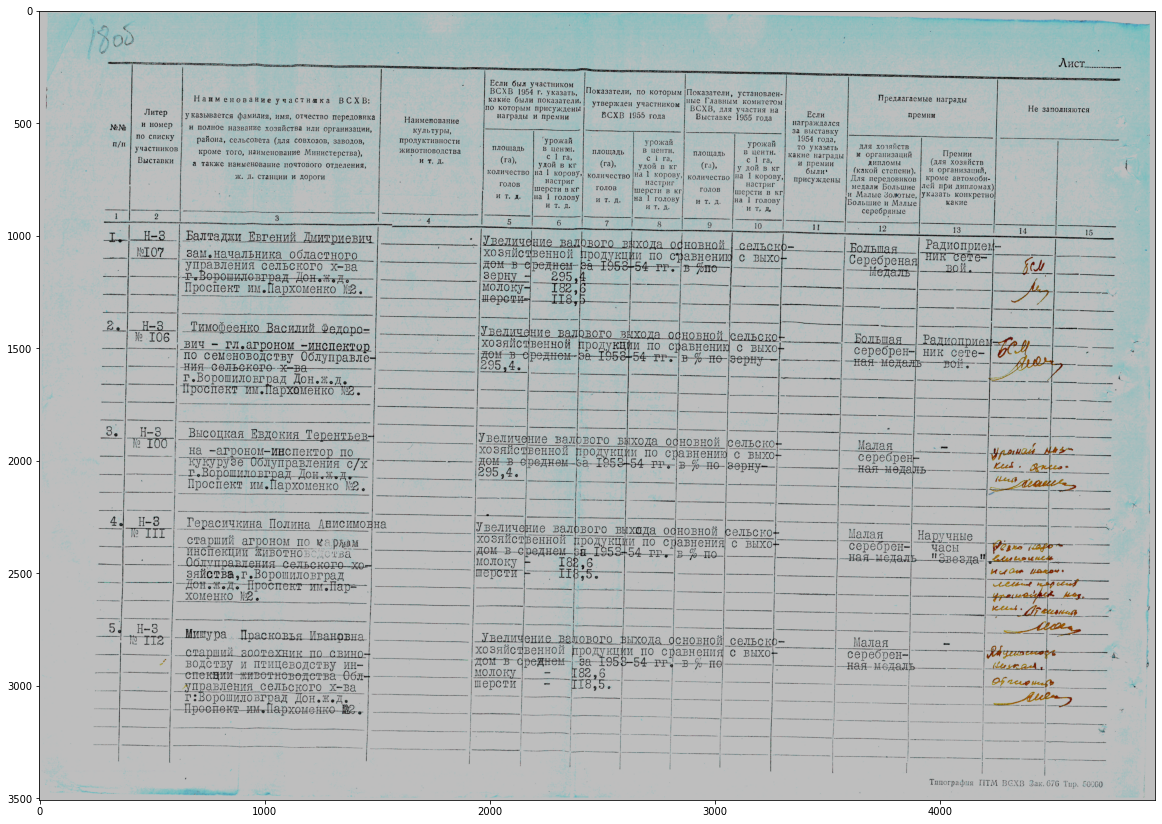

In [9]:
img = cv2.imread(name_jpg)
ret,img_rez = cv2.threshold(img,190,255,cv2.THRESH_TRUNC)
show_image(img_rez)

In [10]:
d = pytesseract.image_to_data(img_rez, output_type=pytesseract.Output.DICT, lang="rus")
n_boxes = len(d['level'])
print(n_boxes)
file_mistakes = open('file_mistakes2.txt','a')
for i in range(400,n_boxes):
    (t, x, y, w, h) = (d['text'][i],d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    img_rez = cv2.rectangle(img_rez, (x, y), (x + w, y + h), (0, 255, 0), 1)
    t = t.strip().replace('|','').replace('.','').replace('--','').replace('—-','').replace('”','')
    if len(t)>1 and len(t)< 15 and not t.isdigit():
        print(t, x, y, w, h, sep=' | ')
        file_mistakes.write(t+'\n')
#show_image(img_rez)

1148
голову | 2292 | 823 | 110 | 28
[На | 2645 | 829 | 35 | 19
голову | 2737 | 830 | 131 | 28
[На | 3091 | 836 | 36 | 19
голову | 3185 | 838 | 110 | 27
Большие | 3594 | 839 | 147 | 29
Малые | 3790 | 829 | 111 | 42
какие | 4032 | 846 | 93 | 20
иаАА, | 3124 | 872 | 129 | 25
серебряные | 3658 | 872 | 191 | 45
ОО | 293 | 886 | 102 | 4
ЕО | 510 | 858 | 46 | 45
ое | 574 | 858 | 30 | 45
Зтерай | 1516 | 886 | 96 | 48
ста | 1524 | 900 | 428 | 13
че | 1876 | 886 | 24 | 48
оо | 1980 | 886 | 36 | 48
НА | 1979 | 908 | 277 | 9
ЗЕНАЙ | 2256 | 886 | 128 | 48
НО | 2408 | 886 | 48 | 48
сН | 2421 | 915 | 210 | 8
ИАЫ | 2646 | 920 | 204 | 8
аЕа | 2820 | 886 | 112 | 48
НАО | 2936 | 886 | 136 | 48
ние | 2193 | 1016 | 87 | 38
вад | 2316 | 1018 | 87 | 37
нхода | 2626 | 1028 | 139 | 29
основной | 2811 | 1021 | 241 | 42
селъьско- | 3114 | 1034 | 241 | 36
хозяйственной | 1976 | 1055 | 398 | 48
родт | 2436 | 1072 | 106 | 42
НЦ | 2558 | 1074 | 72 | 39
П0 | 2713 | 1077 | 56 | 32
СЭВНЭНИ | 2805 | 1079 | 242 | 36
ВЫХО

In [6]:
file_mistakes.close()

## Вариант 2

In [12]:
# This only works if there's only one table on a page
# Important parameters:
#  - morph_size
#  - min_text_height_limit
#  - max_text_height_limit
#  - cell_threshold
#  - min_columns


def pre_process_image(img, morph_size=(10, 10)):

    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu threshold
    pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy

    return pre


In [13]:
def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes

In [14]:
def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells

In [15]:
def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((x, y, x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((x, max_y, max_x, max_y))

    return hor_lines, ver_lines

1022


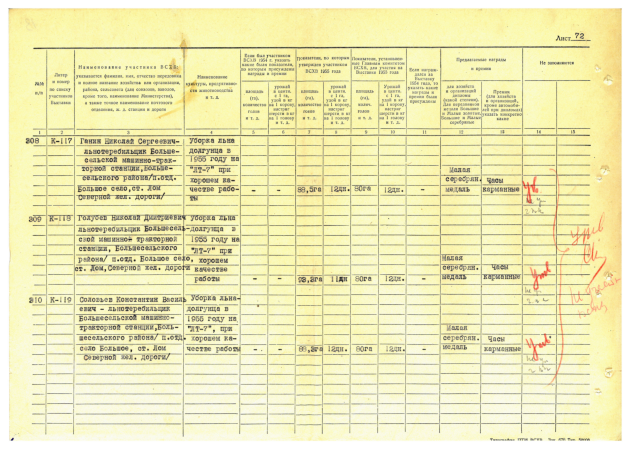

In [16]:
pre_processed = pre_process_image(img)
text_boxes = find_text_boxes(pre_processed)
print(len(text_boxes))
show_image(img)

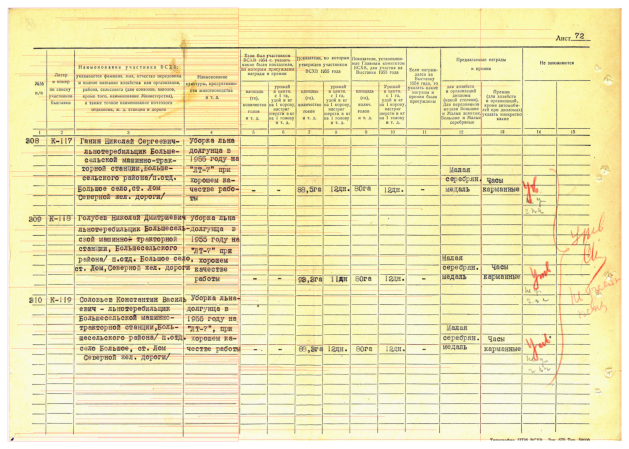

In [17]:
cells = find_table_in_boxes(text_boxes)
hor_lines, ver_lines = build_lines(cells)

# Visualize the result
vis = img.copy()

# for box in text_boxes:
#     (x, y, w, h) = box
#     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

show_image(vis)